In [3]:
import torch
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

In [6]:
np.random.seed(0)
torch.cuda.manual_seed(0)

In [7]:
df = pd.read_csv(r'C:\Users\Deepam Shah\Downloads\AirlineTweets.csv')

In [8]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [9]:
df = df[['airline_sentiment', 'text']]

In [11]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


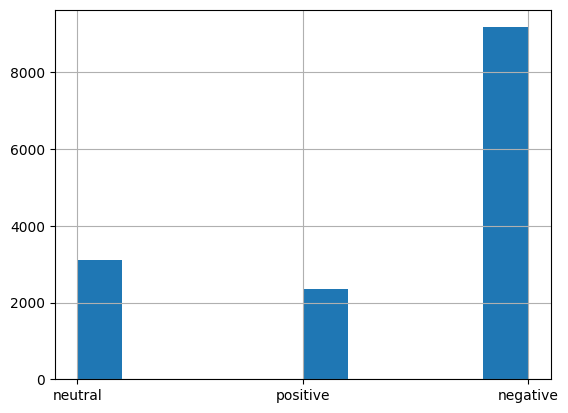

In [13]:
df['airline_sentiment'].hist();

In [14]:
df = df[df['airline_sentiment']!= 'neutral'].copy()

In [15]:
df.head()

,airline_sentiment,text
1,positive,@VirginAmerica plus you've added commercials t...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
5,negative,@VirginAmerica seriously would pay $30 a fligh...
6,positive,"@VirginAmerica yes, nearly every time I fly VX..."


In [16]:
target_map = {'positive': 1, 'negative': 0}
df['target'] = df['airline_sentiment'].map(target_map)

In [17]:
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [18]:
df_train, df_test = train_test_split(df, random_state=42)

In [19]:
vectorizer = TfidfVectorizer(max_features=2000)
X_train = vectorizer.fit_transform(df_train['text'])
X_test = vectorizer.transform(df_test['text'])

In [20]:
# data must not be sparse matrix before passing into pytorch
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

In [23]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_dense, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_dense, dtype=torch.float32)

In [21]:
Y_train = df_train['target']
Y_test = df_test['target']

In [25]:
y_train_tensor = torch.tensor(Y_train.to_numpy(), dtype=torch.long)
y_test_tensor = torch.tensor(Y_test.to_numpy(), dtype=torch.long)

In [84]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

test_ds = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=True)

In [85]:
import torch.nn as nn

class TfIdfClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 1)  # Only 1 output neuron
    
    def forward(self, x):
        return torch.sigmoid(self.fc1(x))  # Apply sigmoid for binary classification

In [86]:
input_size = X_train_tensor.shape[1]
output_dim = len(torch.unique(y_train_tensor))

input_size, output_dim

(2000, 2)

In [87]:
model = TfIdfClassifier(input_dim=input_size)

In [88]:
loss_fn = nn.BCEWithLogitsLoss()  # Use this for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [89]:
from torchinfo import summary

In [90]:
summary(model)

Layer (type:depth-idx)                   Param #
TfIdfClassifier                          --
├─Linear: 1-1                            2,001
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0

In [94]:
num_epochs = 40
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    for X_batch, y_batch in train_loader:
        y_batch = y_batch.unsqueeze(1).float()
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        preds = torch.sigmoid(outputs)
        predicted = (preds > 0.5).float()
        total_correct += (predicted == y_batch).sum().item()
        total_samples += y_batch.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = total_correct / total_samples * 100
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # --- Validation inside epoch loop ---
    model.eval()
    correct = 0
    total = 0
    val_loss = 0

    with torch.inference_mode():
        for X_batch, y_batch in test_loader:
            y_batch = y_batch.unsqueeze(1).float()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            val_loss += loss.item()

            preds = torch.sigmoid(outputs)
            predicted = (preds > 0.5).float()
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    val_loss /= len(test_loader)
    val_acc = correct / total * 100
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Correct print statements
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch [1/40] | Train Loss: 0.6799, Train Acc: 20.80% | Val Loss: 0.6776, Val Acc: 19.51%
Epoch [2/40] | Train Loss: 0.6710, Train Acc: 20.80% | Val Loss: 0.6713, Val Acc: 19.51%
Epoch [3/40] | Train Loss: 0.6640, Train Acc: 20.80% | Val Loss: 0.6668, Val Acc: 19.51%
Epoch [4/40] | Train Loss: 0.6588, Train Acc: 20.80% | Val Loss: 0.6639, Val Acc: 19.51%
Epoch [5/40] | Train Loss: 0.6548, Train Acc: 20.80% | Val Loss: 0.6616, Val Acc: 19.51%
Epoch [6/40] | Train Loss: 0.6519, Train Acc: 20.80% | Val Loss: 0.6601, Val Acc: 19.51%
Epoch [7/40] | Train Loss: 0.6495, Train Acc: 20.80% | Val Loss: 0.6596, Val Acc: 19.51%
Epoch [8/40] | Train Loss: 0.6474, Train Acc: 20.80% | Val Loss: 0.6586, Val Acc: 19.51%
Epoch [9/40] | Train Loss: 0.6457, Train Acc: 20.80% | Val Loss: 0.6580, Val Acc: 19.51%
Epoch [10/40] | Train Loss: 0.6442, Train Acc: 20.80% | Val Loss: 0.6567, Val Acc: 19.51%
Epoch [11/40] | Train Loss: 0.6429, Train Acc: 20.80% | Val Loss: 0.6568, Val Acc: 19.51%
Epoch [12/40] | Tra

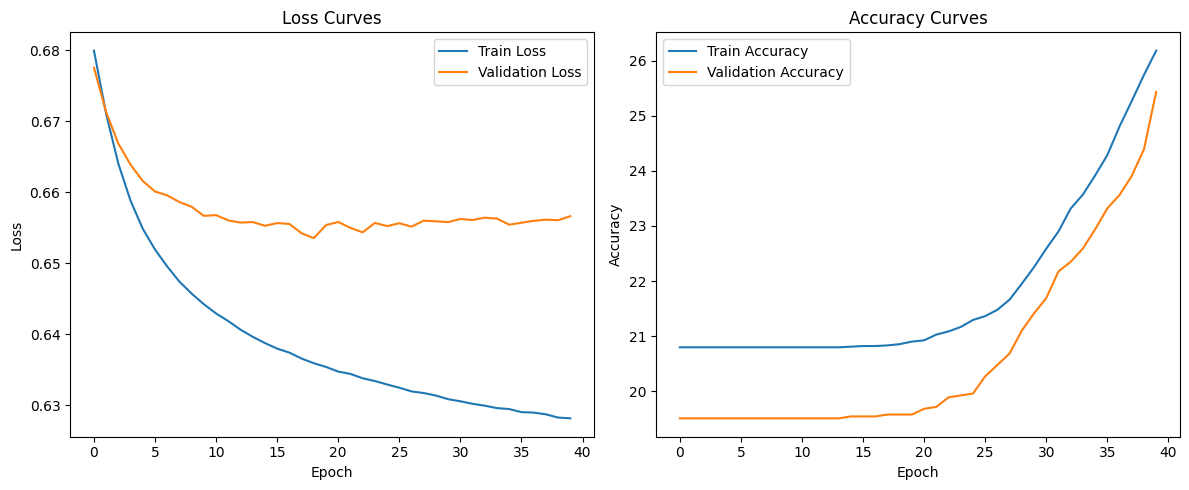

In [95]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.tight_layout()
plt.show()


In [97]:
# Set model to evaluation mode
model.eval()

with torch.inference_mode():
    # Get raw logits
    outputs_train = model(X_train_tensor)
    outputs_test = model(X_test_tensor)

    # Apply threshold at 0.0 (or sigmoid + 0.5)
    # If model has sigmoid output
    P_train = (outputs_train > 0.5).float().flatten()
    P_test = (outputs_test > 0.5).float().flatten()

In [98]:
cm = confusion_matrix(Y_train, P_train, normalize='true')
cm

array([[0.99781182, 0.00218818],
       [0.1       , 0.9       ]])

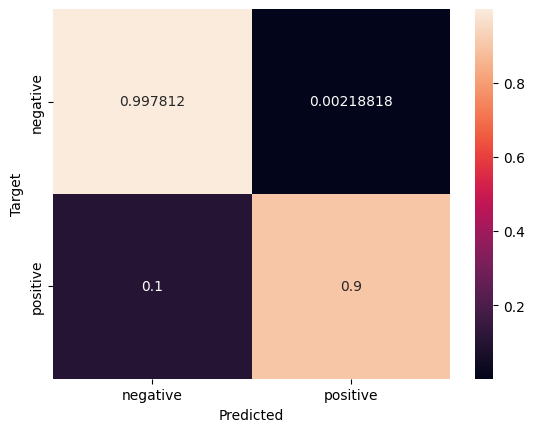

In [99]:
def plot_cm(cm):
    classes = ['negative', 'positive']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sns.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")
plot_cm(cm)

In [100]:
cm_test = confusion_matrix(Y_test, P_test, normalize='true')
cm_test

array([[0.97158846, 0.02841154],
       [0.28419183, 0.71580817]])

In [103]:
# Access weights and biases of fc2
weights = model.fc1.weight.detach().numpy()
biases = model.fc1.bias.detach().numpy()

In [104]:
print([weights, biases])

[array([[ -6.2967267,   7.860791 ,  -4.1348214, ...,   4.996073 ,
          4.7206836, -10.029378 ]], dtype=float32), array([-0.7058431], dtype=float32)]


In [105]:
w = weights

In [106]:
word_index_map = vectorizer.vocabulary_
word_index_map

{'jetblue': 973,
 'thanks': 1726,
 'for': 753,
 'having': 855,
 'us': 1859,
 'hang': 838,
 'out': 1262,
 'at': 197,
 'tampa': 1708,
 'airport': 122,
 'forever': 756,
 'today': 1767,
 'it': 964,
 'really': 1420,
 'been': 243,
 'an': 147,
 'awesome': 217,
 'experience': 654,
 'americanair': 143,
 'was': 1898,
 'told': 1770,
 'you': 1993,
 'could': 452,
 'only': 1245,
 'refund': 1434,
 'me': 1107,
 'the': 1730,
 'cost': 448,
 'of': 1224,
 'my': 1179,
 'original': 1254,
 'return': 1476,
 'flight': 726,
 'note': 1211,
 'had': 828,
 'booked': 273,
 'more': 1164,
 'expensive': 653,
 'everyone': 635,
 'else': 602,
 'outstanding': 1267,
 'united': 1842,
 'denver': 516,
 'to': 1766,
 'austin': 207,
 'still': 1660,
 'on': 1239,
 'ground': 820,
 'issue': 961,
 'is': 959,
 'lack': 999,
 'announcement': 151,
 'made': 1086,
 'so': 1606,
 'late': 1010,
 'when': 1929,
 'gate': 793,
 'agent': 113,
 'there': 1734,
 'over': 1268,
 'hour': 897,
 'southwestair': 1626,
 'hold': 880,
 '30': 36,
 'min': 1141,


In [108]:
# let's look at the weights for each word
# try it with different threshold values!
threshold = 2

print("Most positive words:")
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = w[0, index]
    if weight > threshold:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: -x[1])
for i in range(10):
    word, weight = word_weight_tuples[i]
    print(word, weight)

Most positive words:
thank 20.171692
thanks 18.662052
worries 18.07312
excellent 16.14328
awesome 15.169897
kudos 14.685274
great 14.378933
love 13.44126
excited 11.418484
best 11.056579


In [110]:
# let's look at the weights for each word
# try it with different threshold values!
threshold = 2

print("Most negative words:")
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = w[0, index]
    if weight < -threshold:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: x[1])
for i in range(10):
    word, weight = word_weight_tuples[i]
    print(word, weight)

Most negative words:
worst -20.00915
rude -15.230962
not -14.517918
disappointed -13.930854
delayed -13.328994
nothing -13.252402
paid -12.870058
says -12.830052
hold -12.684365
worse -12.588255
